In [70]:
import json
import re
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib.pyplot import cm
from scipy.spatial import distance
from shapely.geometry import ( 
    LineString,
    Point,)
import seaborn as sns

# Constructing Network

### Load LU shapefiles

In [71]:
# read in the data using geopandas
stations = gpd.read_file("source_data/network/tfl_stations.json")
lines = gpd.read_file("source_data/network/tfl_lines.json")

In [72]:
# project data to British National Grid
# we do this so we can work in meters
stations = stations.to_crs(epsg=27700)
lines = lines.to_crs(epsg=27700)

### Stations file

In [73]:
stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   id           529 non-null    object  
 1   name         529 non-null    object  
 2   nlc_id       518 non-null    object  
 3   lines        529 non-null    object  
 4   cartography  529 non-null    object  
 5   altmodeid    16 non-null     object  
 6   alt_id       337 non-null    object  
 7   altmodeid2   2 non-null      object  
 8   zone         529 non-null    object  
 9   geometry     529 non-null    geometry
dtypes: geometry(1), object(9)
memory usage: 41.5+ KB


In [74]:
stations[stations["nlc_id"].isna()]

,id,name,nlc_id,lines,cartography,altmodeid,alt_id,altmodeid2,zone,geometry
273,940GZZLU960,Cassiobridge,None,"[ { ""name"": ""Metropolitan"", ""opened"": 9999 } ]","{'labelX': 25, 'labelY': -20}",None,None,None,M,POINT (509104.748 195823.363)
274,940GZZLU961,Watford Vicarage Road,None,"[ { ""name"": ""Metropolitan"", ""opened"": 9999 } ]","{'labelX': -1, 'labelY': 50, 'display_name': '...",None,None,None,M,POINT (510200.643 195420.488)
275,940GZZLU990,Nine Elms,None,"[ { ""name"": ""Northern"", ""opened"": 2020 } ]","{'labelX': -1, 'labelY': 35}",None,None,None,2,POINT (530049.490 177348.742)
276,940GZZLU991,Battersea Power Station,None,"[ { ""name"": ""Northern"", ""opened"": 2020 } ]","{'labelX': -25, 'labelY': -20}",None,None,None,2,POINT (529053.258 177243.076)
373,910GBONDST,Bond Street (Rail),None,"[ { ""name"": ""Crossrail"", ""opened"": 2018 } ]","{'labelX': -1, 'labelY': 45, 'display_name': '...",None,None,None,1,POINT (528610.077 181011.652)
450,910GLIVSTLL,Liverpool Street (Crossrail),None,"[ { ""name"": ""Crossrail"", ""opened"": 2018 } ]","{'labelX': -1, 'labelY': -45, 'display_name': ...",None,None,None,1,POINT (533023.221 181648.264)
465,910GPADTLL,Paddington (Crossrail),None,"[ { ""name"": ""Crossrail"", ""opened"": 2018 } ]","{'labelX': -25, 'labelY': 20, 'display_name': ...",None,None,None,1,POINT (526541.548 181271.292)
504,910GTOTCTRD,Tottenham Court Road (Rail),None,"[ { ""name"": ""Crossrail"", ""opened"": 2018 }, { ""...","{'labelX': 20, 'labelY': 40, 'display_name': '...",None,-930,None,1,POINT (529748.987 181274.281)
525,910GWOLWXR,Woolwich,None,"[ { ""name"": ""Crossrail"", ""opened"": 2018 } ]","{'labelX': 25, 'labelY': -20}",None,None,None,4,POINT (543860.265 179015.536)
527,910G950,Canary Wharf,None,"[ { ""name"": ""Crossrail"", ""opened"": 2018 } ]",{'labelX': 30},None,None,None,2,POINT (537688.715 180457.643)


<AxesSubplot:>

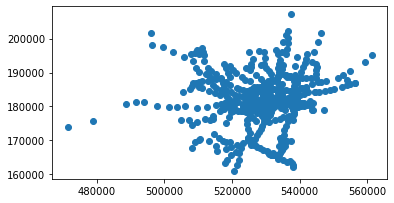

In [75]:
stations.plot()

### Clean station names

We have multiple points representing one station (for example Paddington has seperate points for different entrances). We will simplify this by using RegEx make the names consistent. 

Once we have cleaned the names we can set the coordinate of these stations to the mean values of the coordinates of all the stations with the same name.

In [76]:
# get all station names
station_names = {row.id: row["name"] for i, row in stations.iterrows()}

In [77]:
# clean station names
for k, v in station_names.items():
    if k == "none":
        continue
    cleaned_name = re.sub(
        "\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)|['\.]", "", v
    )

    # #note that bank and monument are enconded as one station in our TFL data, so we will do the same
    # if cleaned_name in ['Barkingside']:
    #     cleaned_name = 'Barking Riverside'
    station_names[k] = cleaned_name

stations["name"] = stations["id"].apply(lambda x: station_names[x])

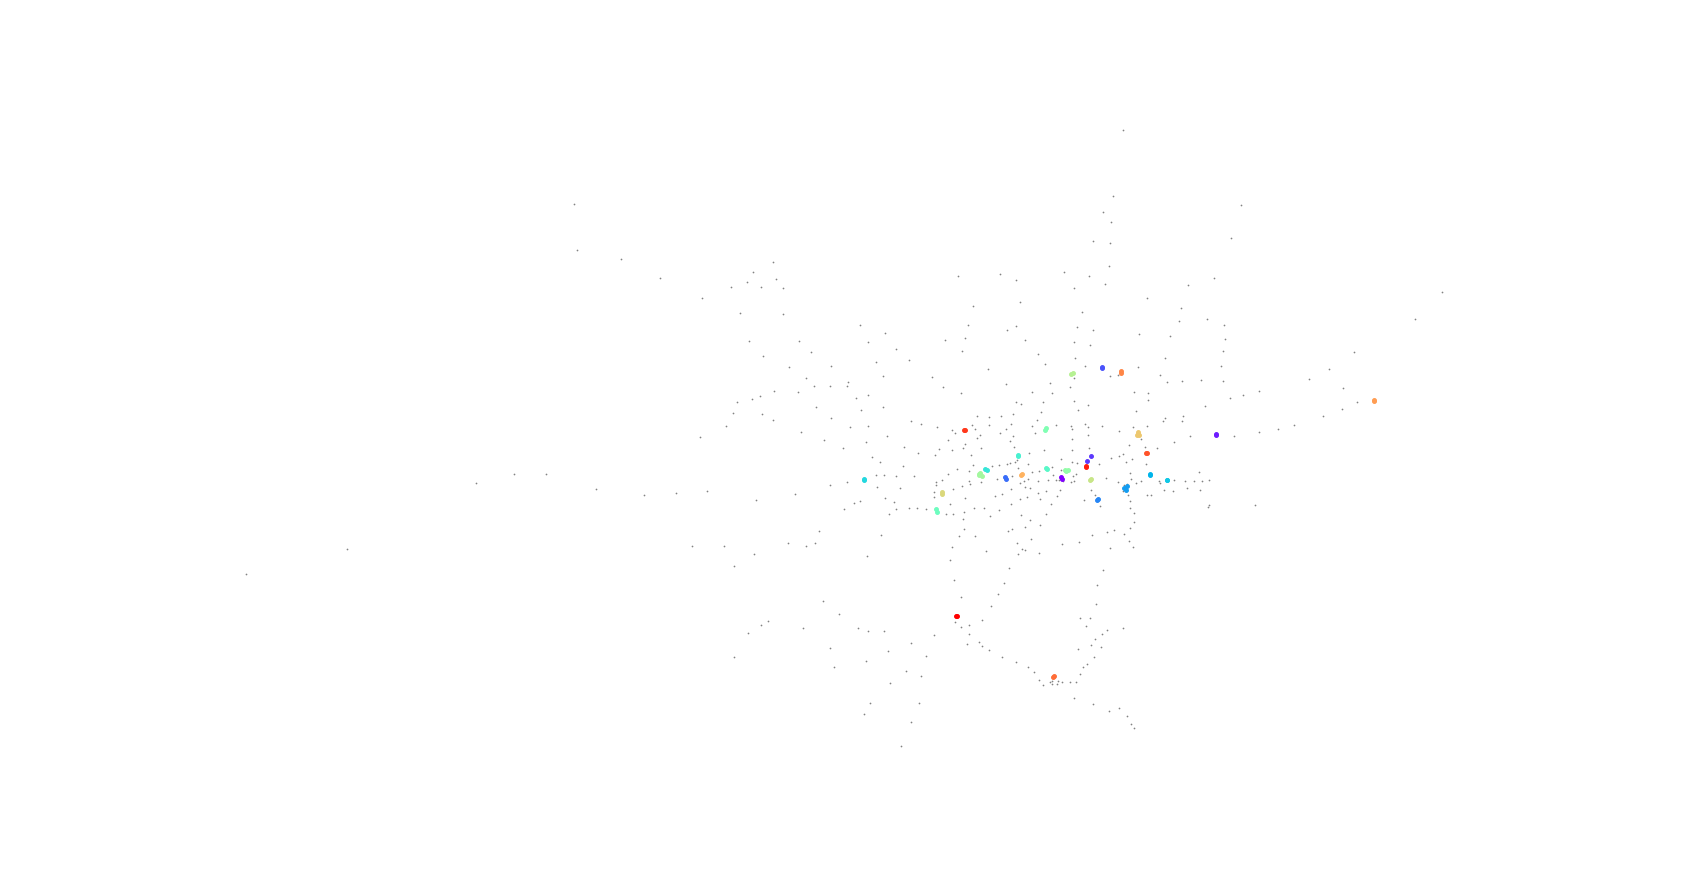

In [78]:
## we will plot all the stations with multiple points to check there are no errors
fig, ax = plt.subplots(figsize=(30, 30))
ax.set_aspect("equal")
ax.axis("off")
ax.margins(0.2)
color = iter(cm.rainbow(np.linspace(0, 1, 29)))
stations.plot(ax=ax, color="grey", markersize=0.5)
for i, group in stations.groupby("name"):
    if len(group) > 1:
        group.plot(ax=ax, color=next(color), markersize=15)
plt.show()

**Change position of station to mean of all station with the same name**

In [79]:
# get position of stations as mean of x, y of stations

# create empty dict to store list of coordinates
pos = {}

# iterate through the stations
for i, station in stations.iterrows():
    xy = station.geometry.coords[0]

    # if station already in dict add coordinate to coordinate list
    if station["name"] in pos.keys():
        pos[station["name"]].extend([xy])
    # if station is not in the dict add station to dict and set first coordinate in list
    else:
        pos[station["name"]] = [xy]

# iterate through our dict and replace coordinate list with mean value
for k, v in pos.items():
    # we set axis to 0 to make sure to take mean of x and y coordinates
    pos[k] = np.mean(v, axis=0)

In [80]:
# set new geometry
stations["geometry"] = stations["name"].apply(lambda x: Point(pos[x]))

In [81]:
tramlink = stations[stations["lines"] == '[ { "name": "Tramlink" } ]']
tramlink_list = tramlink["name"]
crossrail2 = ["Kings Road Chelsea"]

stations = stations[~stations["name"].isin(tramlink_list)]
stations = stations[~stations["name"].isin(crossrail2)]
stations[stations["lines"] == 'TfL Rail']

,id,name,nlc_id,lines,cartography,altmodeid,alt_id,altmodeid2,zone,geometry


488


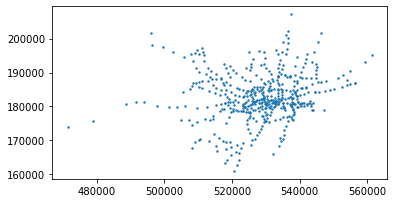

In [82]:
# check plot to make sure there are no errors
stations.plot(markersize=2)
print(len(stations))

### Lines file

In [83]:
lines.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        701 non-null    object  
 1   lines     701 non-null    object  
 2   geometry  701 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 16.6+ KB


<AxesSubplot:>

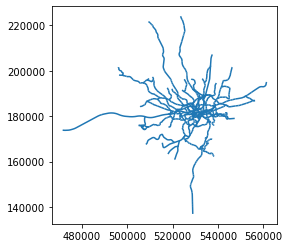

In [84]:
lines.plot()

### Get line names

We can see from our lines geodataframe that one geometry can represent multiple lines (for example one for the circle line and another for hammersmith and city) that go between the same stations. 

Let's work each line seperately to make cleaning and checking the data easier. 

In [85]:
# get all line types as a list and subset geoms by lines
line_names = lines.lines.apply(lambda x: [x["name"] for x in json.loads(x)])
line_names = list(set([item for sublist in line_names for item in sublist]))
line_names

['TfL Rail',
 'District',
 'Crossrail 2',
 'Northern',
 'East London',
 'Thameslink 6tph line',
 'Waterloo & City',
 'Piccadilly',
 'Circle',
 'DLR',
 'Victoria',
 'Bakerloo',
 'Central',
 'Crossrail',
 'Metropolitan',
 'Emirates Air Line',
 'London Overground',
 'Hammersmith & City',
 'Tramlink',
 'Jubilee']

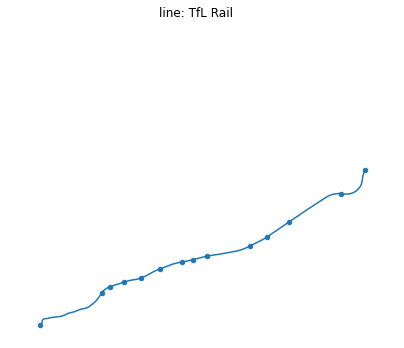

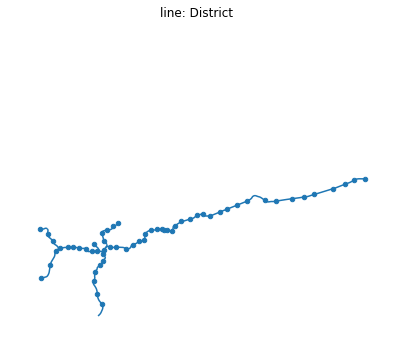

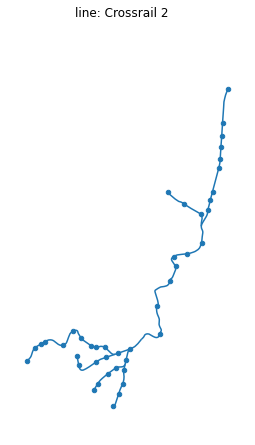

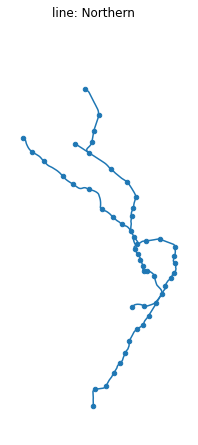

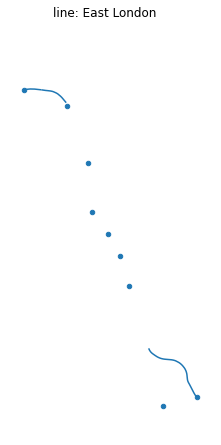

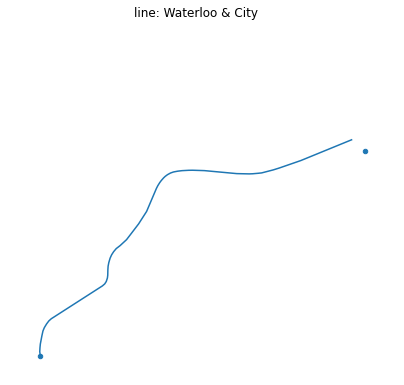

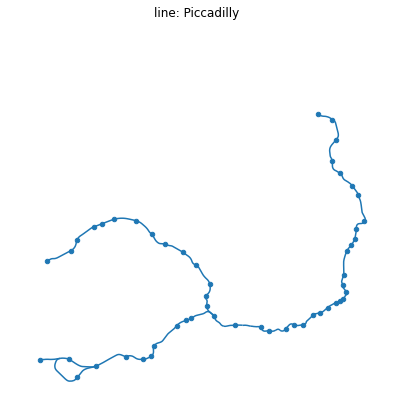

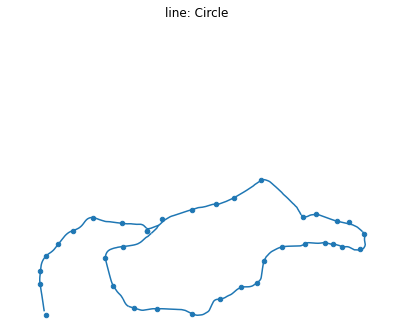

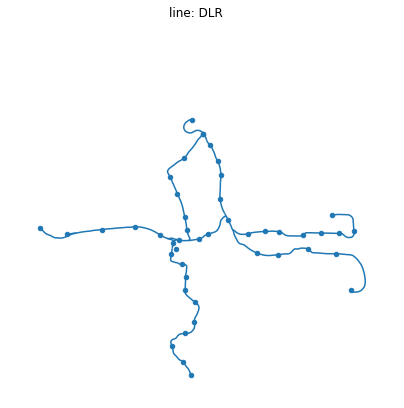

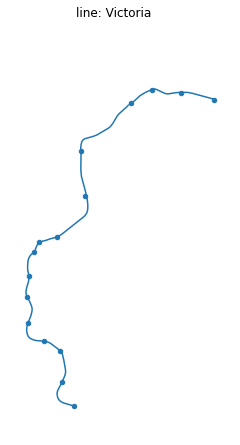

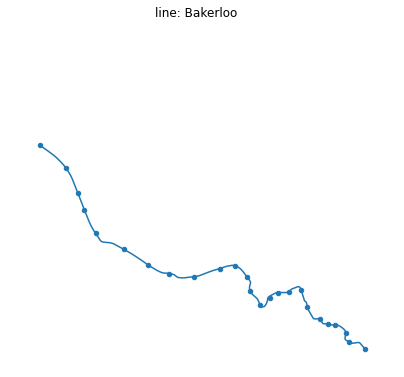

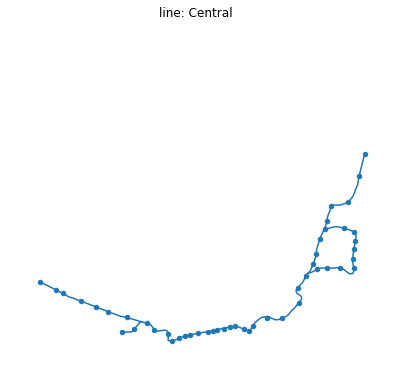

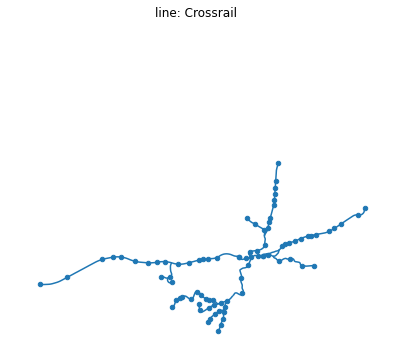

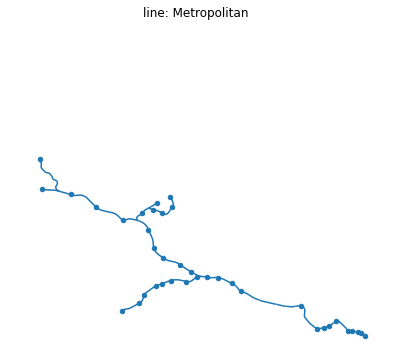

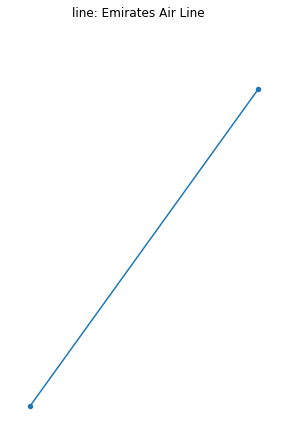

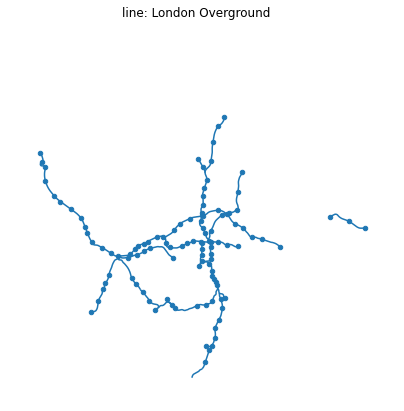

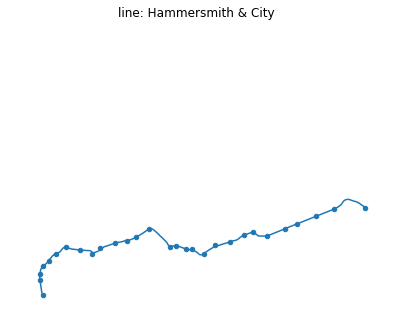

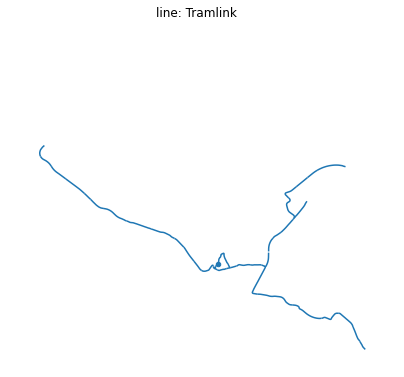

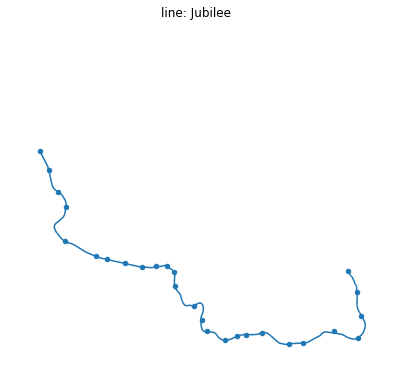

In [86]:
# check the data for each line
for line in line_names:
    # I'm removing thameslink 6tph line because there are not corresponding stations in station file
    if line == "Thameslink 6tph line":
        continue
    fig, ax = plt.subplots(figsize=(7, 7))
    fig.suptitle(f"line: {line}")
    ax.set_aspect("equal")
    ax.axis("off")
    ax.margins(0.1)
    temp_lines = lines[lines.lines.str.contains(line)]
    base = temp_lines.plot(ax=ax)
    temp_stations = stations[stations.lines.str.contains(line)]
    temp_stations.plot(ax=base, markersize=20)
    plt.show()

In [87]:
# merge East London line and LO 
lines.lines = lines.lines.str.replace("East London", "London Overground")
stations.lines = stations.lines.str.replace("East London", "London Overground")

In [88]:
# exclude lines that we are not going to use
excluded_lines = ["Crossrail 2", "Crossrail", "Tramlink", "East London"]  # Thameslink 6tph line

### Create seperate graphs for each line and then join

Since we don't have properly constructed line geometries because:
* there are discontinuities in the line geometries
* a line between two stations can actually be composed of more than one geometry

We will construct geometric graphs (meaning graphs just from the line geometries where nodes are coordinates that define the line geometry). It's easy to fix the discontinuities in this manner because the can be thought of as nodes with degree = 1 that have another node with degree = 1 within a threshold distance. 

Once we have these discontinuties fixed we can use these geometric graphs to construct proper geometries between stations by taking the shortest paths within these networks starting from the node closest to the origin station and ending in the node closest to the destination station. The shortest path will then be a list of coordinates that define the line geometry between the two stations. 

TfL Rail


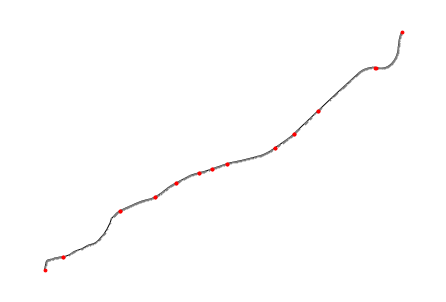

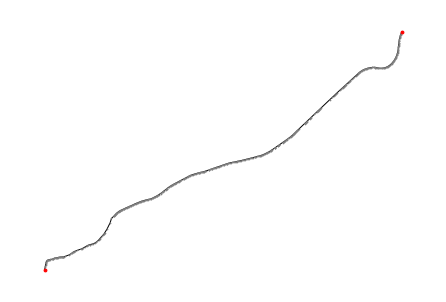

1
District


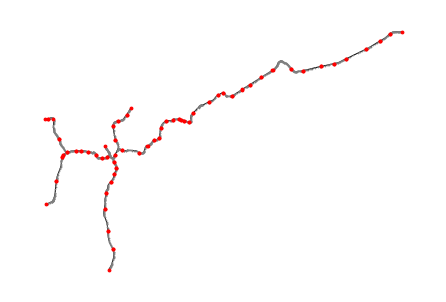

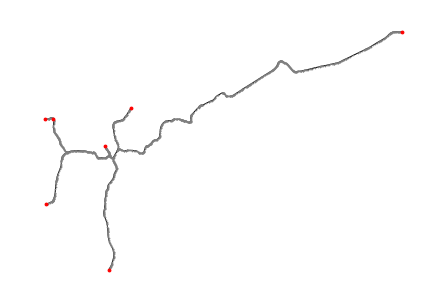

1
Northern


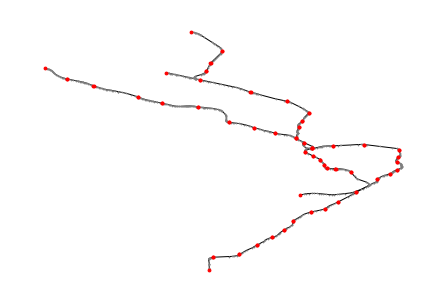

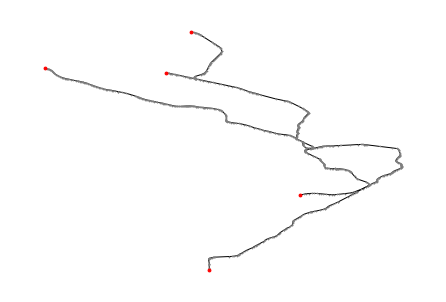

1
Thameslink 6tph line


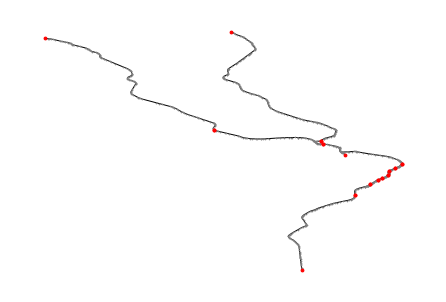

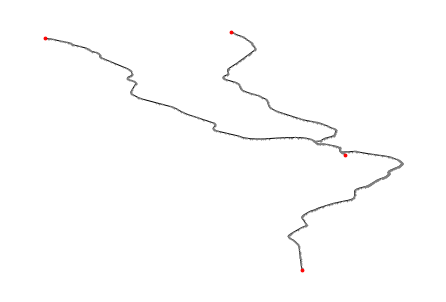

1
Waterloo & City


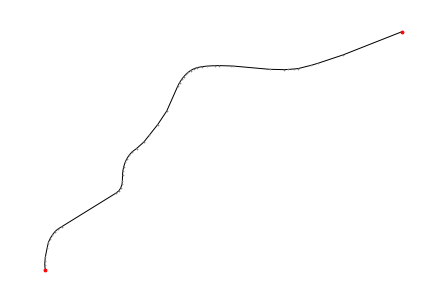

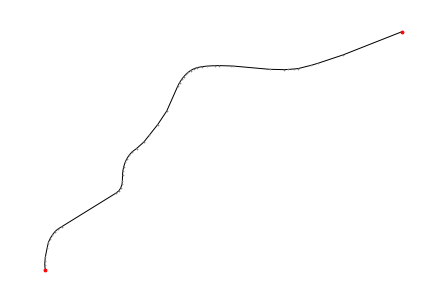

1
Piccadilly


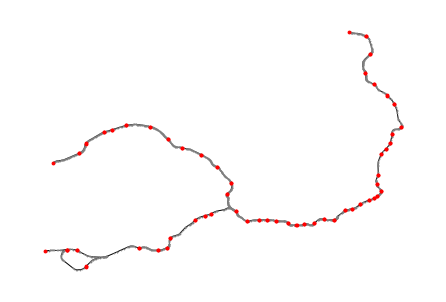

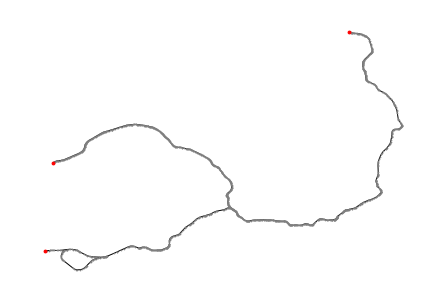

1
Circle


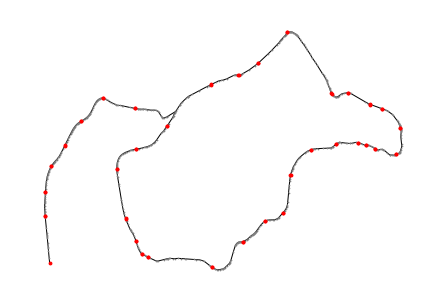

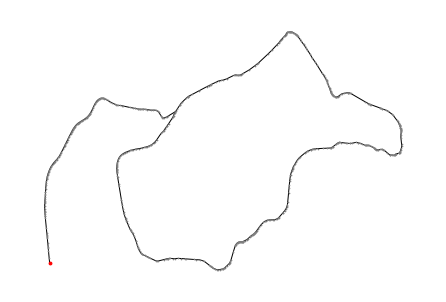

1
DLR


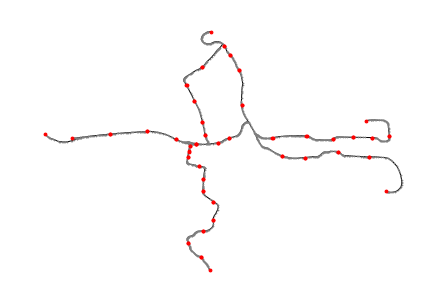

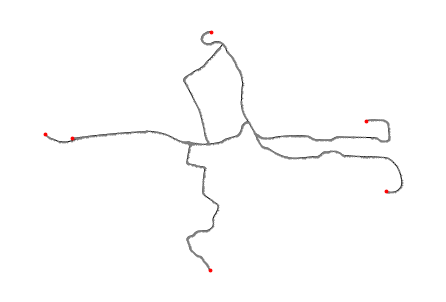

1
Victoria


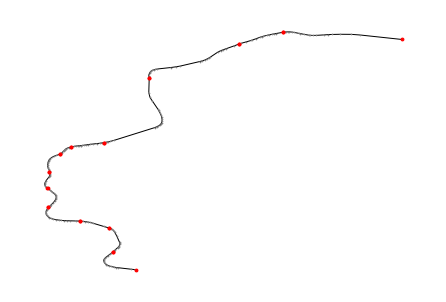

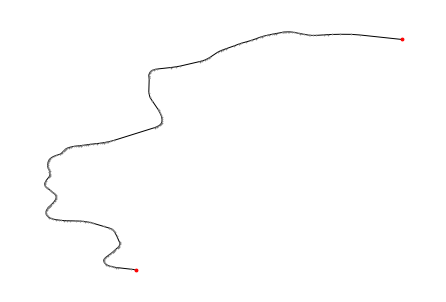

1
Bakerloo


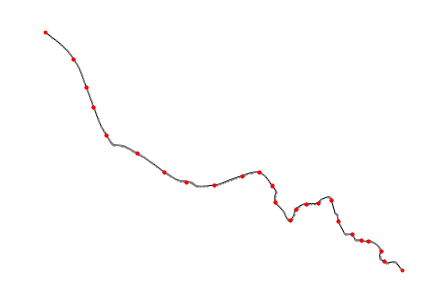

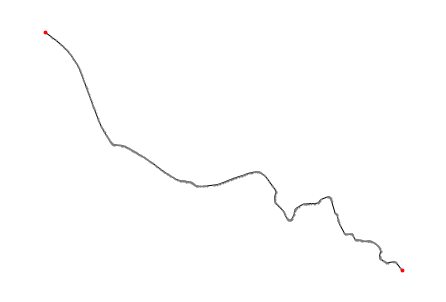

1
Central


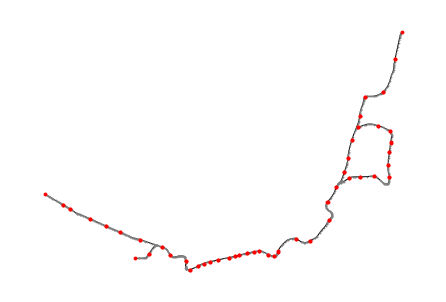

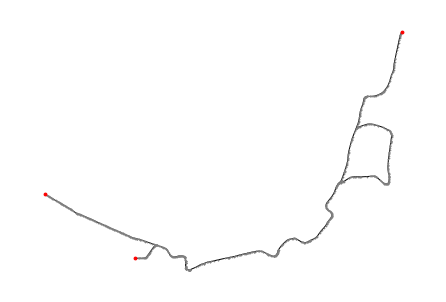

1
Metropolitan


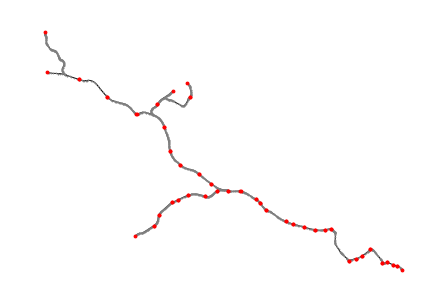

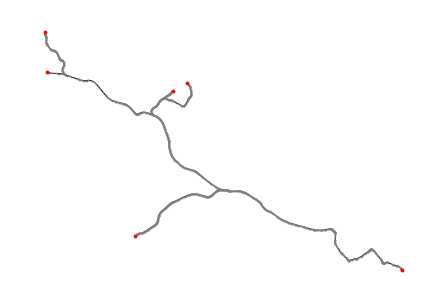

1
Emirates Air Line


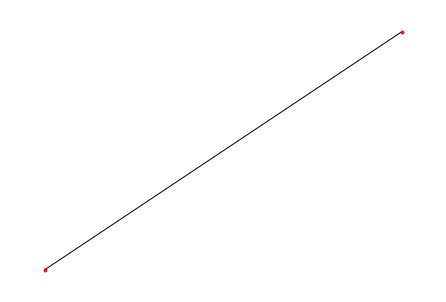

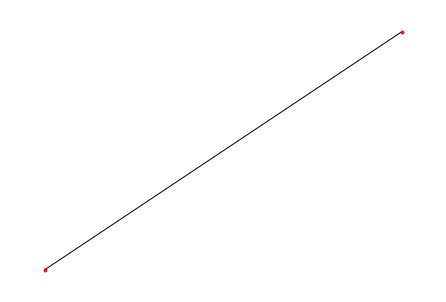

1
London Overground


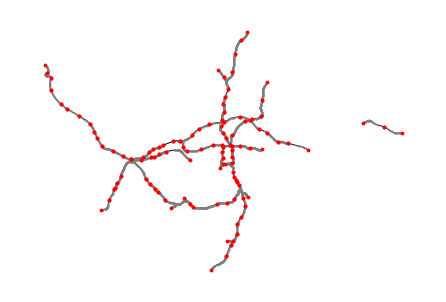

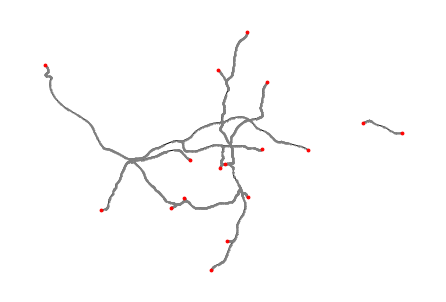

3
Hammersmith & City


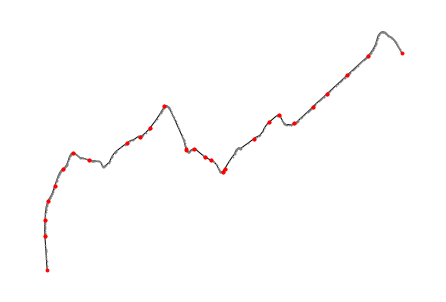

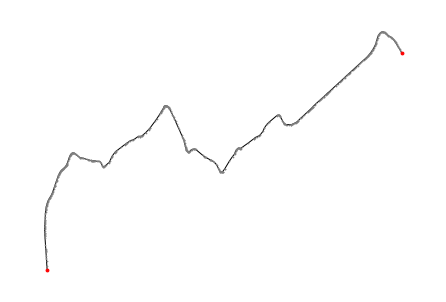

1
Jubilee


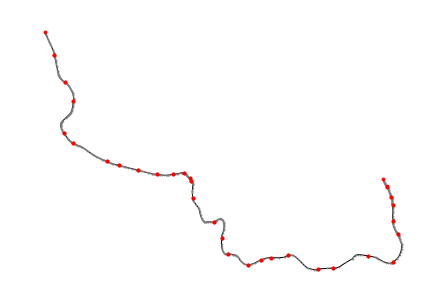

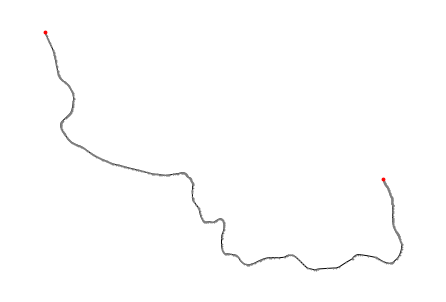

1


In [89]:
# create an empty dict to hold our geometric graphs
geometric_graphs = {}

# iterate through each line individually
for line_name in line_names:
    # skip lines that we won't be using
    if line_name in excluded_lines:
        continue
    print(line_name)

    # subset our line and station files for the ones the belong to a specific line
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]

    # create empty graph
    G = nx.Graph()

    # iterate through our line geometries
    for i, line in temp_lines.iterrows():
        # get list of coordinates that define our line
        _l = list(line.geometry.coords)

        # add coordinates as edges
        G.add_edges_from(list(zip(_l, _l[1:])))

    # remove any self loops
    G.remove_edges_from(nx.selfloop_edges(G))

    # the position of the node is the name of the node
    # let's extract this to plot our graph
    pos = {n: n for n in G.nodes()}

    # get degree one nodes
    D = nx.degree(G)
    k1 = [node for node, degree in D if degree == 1]
    # let's plot our graph and all degree one nodes
    nx.draw(G, pos=pos, node_size=0.5, node_color="grey")
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color="red", node_size=8)
    plt.show()

    # get distance between all points of 1-degree, this will be a matrix
    dist = distance.cdist(k1, k1)

    # add edges between points that are close
    for j in range(dist.shape[0] - 1):
        temp = dist[j][j + 1 :]
        # get index of closest node
        i_min = np.argmin(temp)
        if dist[j][i_min + j + 1] < 50:
            G.add_edge(k1[j], k1[i_min + j + 1])

    # recalculate degree
    D = nx.degree(G)
    k1 = [node for node, degree in D if degree == 1]
    # plot new graph
    nx.draw(G, pos=pos, node_size=0.5, node_color="grey")
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color="red", node_size=8)
    plt.show()
    print(nx.number_connected_components(G))
    # store graph in dictionary
    geometric_graphs[line_name] = G

Now that we have these geometric graphs we can create our final graph by using the data in the lines attribute in our lines geodataframe that contains origin and destination station. We can then use our geometric graph and find the shortest route to create our line geometries and find the length of the lines. 

We will store this information in a dataframe that we can use to create our final graph

In [90]:
# create a dataframe with all geometries from all valid lines
# this list will contain a dictionary for each edge in our graph that contains
# node pairs, line name, and a geometry (this is just for quick visualization purposes and will be replaced by true geometry)
edge_list = []


def _has_ids(k):
    # helper function to check if line contains id of start and end station
    if ("start_sid" in k.keys()) and ("end_sid" in k.keys()):
        return True
    else:
        return False


# iterate through each line seperately
for line_name in line_names:
    if line_name in excluded_lines:
        continue

    # subset lines and stations
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]

    # for each line in our subset dataframe get each origin and destination pair
    for i, line in temp_lines.iterrows():
        for k in json.loads(line.lines):
            if k["name"] == line_name:
                if _has_ids(k):
                    # get start and end station ids
                    start_id = k["start_sid"]
                    end_id = k["end_sid"]

                    # get info of start and end station
                    start_station = temp_stations[
                        (temp_stations.id == start_id)
                        | (temp_stations.altmodeid == start_id)
                    ].values
                    end_station = temp_stations[
                        (temp_stations.id == end_id)
                        | (temp_stations.altmodeid == end_id)
                    ].values

                    # if no matching station exist, let's just take the starting and ending coordinate of the line for now
                    if len(start_station) >= 1 and len(end_station) >= 1:
                        s_geom = start_station[0][-1].coords[0]
                        e_geom = end_station[0][-1].coords[0]
                        edge_list.append(
                            {
                                "line_name": line_name,
                                "start_id": start_id,
                                "end_id": end_id,
                                "geometry": LineString([s_geom, e_geom]),
                            }
                        )

,line_name,start_id,end_id,geometry
0,TfL Rail,910GLIVST,910GSTFD,"LINESTRING (533127.765 181621.330, 538524.786 ..."
1,TfL Rail,910GSTFD,910GLIVST,"LINESTRING (538524.786 184373.341, 533127.765 ..."
2,TfL Rail,910GSTFD,910GMRYLAND,"LINESTRING (538524.786 184373.341, 539211.234 ..."
3,TfL Rail,910GMRYLAND,910GFRSTGT,"LINESTRING (539211.234 184941.032, 540441.605 ..."
4,TfL Rail,910GMANRPK,910GILFORD,"LINESTRING (541934.264 185711.949, 543586.683 ..."


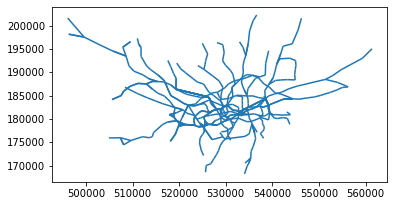

In [91]:
# turn our dictionary list into a geopandas df to quickly plot and sanity check our work
edge_gdf = gpd.GeoDataFrame(edge_list)
edge_gdf.crs = lines.crs
edge_gdf.plot()
edge_gdf.head()

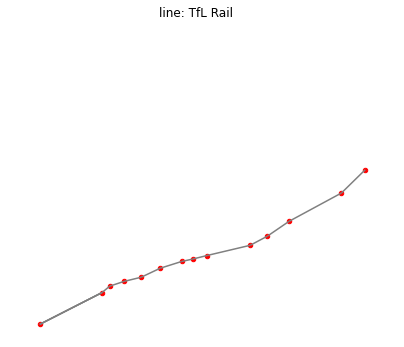

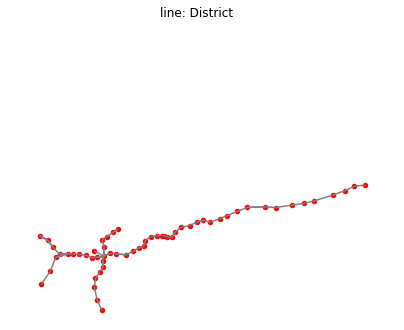

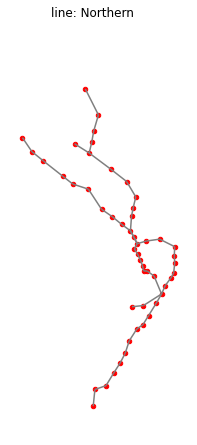

/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


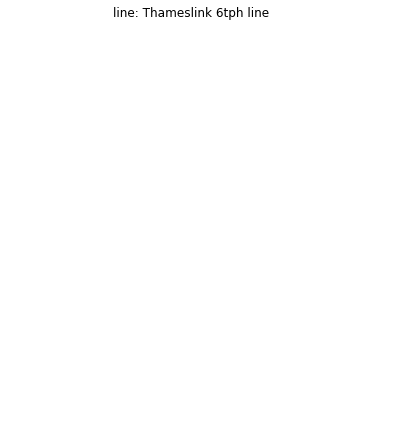

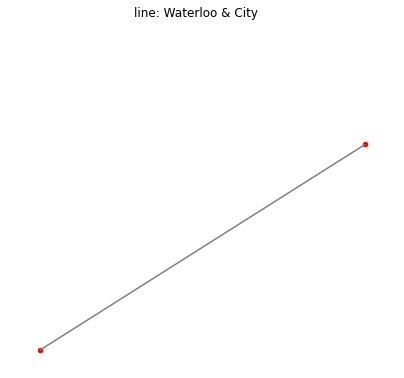

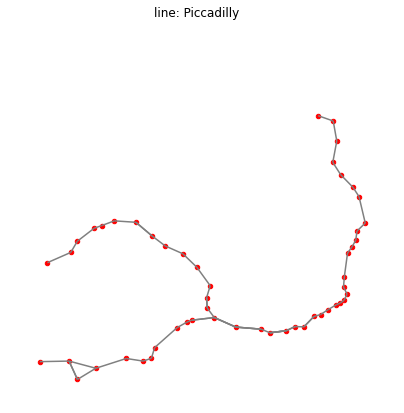

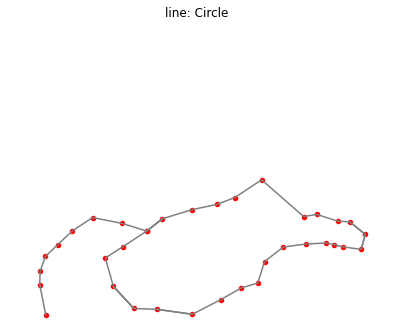

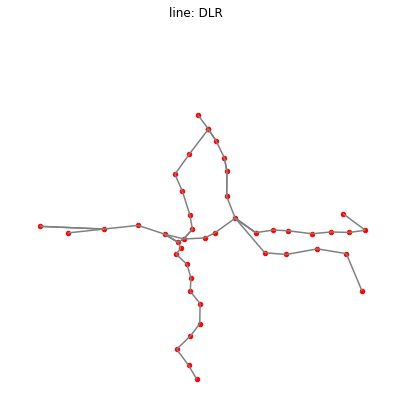

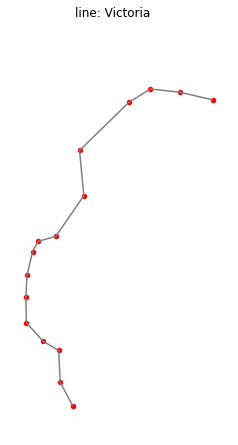

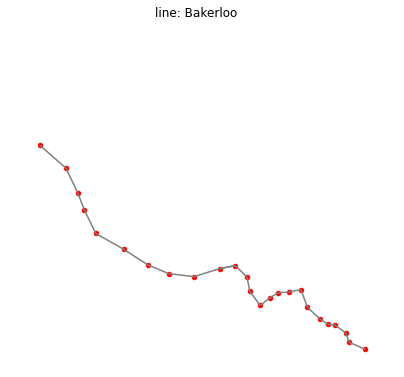

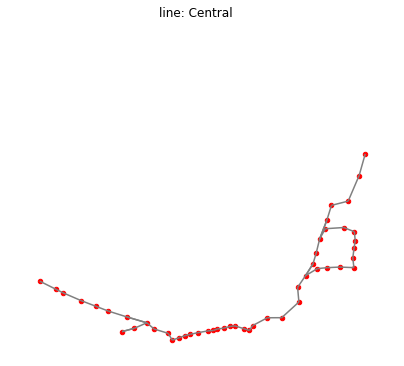

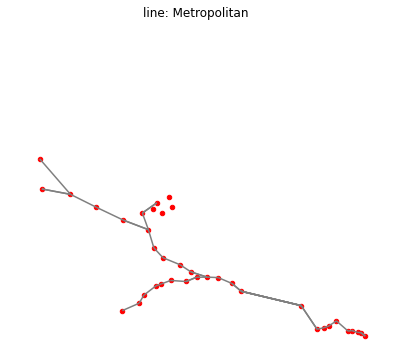

/opt/conda/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


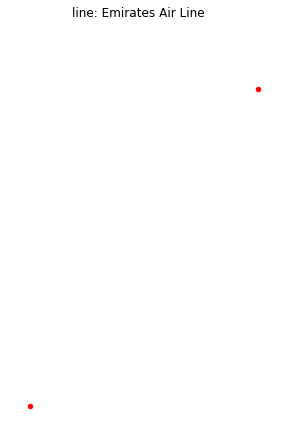

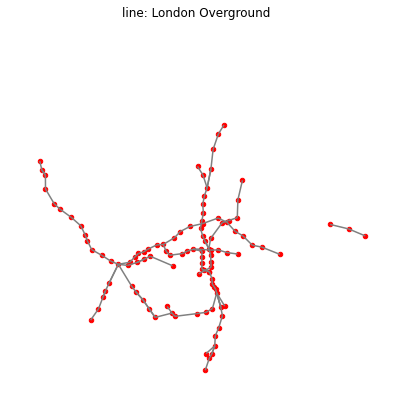

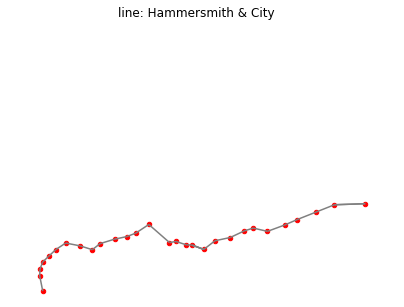

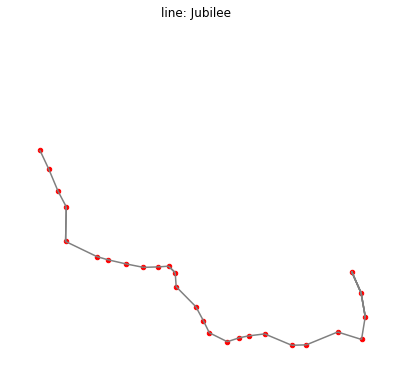

In [92]:
### Add geometry information back into the graph
for line_name in line_names:
    if line_name in excluded_lines:
        continue
    temp_lines = edge_gdf[edge_gdf.line_name == line_name]
    temp_stations = stations[stations.lines.str.contains(line_name)]

    # let's plot our lines so we can check them
    fig, ax = plt.subplots(figsize=(7, 7))
    fig.suptitle(f"line: {line_name}")
    ax.set_aspect("equal")
    ax.axis("off")
    ax.margins(0.1)

    base = temp_lines.plot(ax=ax, color="grey")
    temp_stations.plot(ax=base, markersize=20, color="red")
    plt.show()

    # add real geometry back
    for i, edge in temp_lines.iterrows():
        # get start and end of line coordinates
        start = edge.geometry.coords[0]
        end = edge.geometry.coords[-1]

        # let's get all the coordinates in our geometric graph
        nodes = list(geometric_graphs[line_name].nodes)

        # find nearest node in graph to origin and destination
        s_dist = distance.cdist([start], nodes)[0]
        s_i = np.argmin(s_dist)
        source = nodes[s_i]

        t_dist = distance.cdist([end], nodes)[0]
        t_i = np.argmin(t_dist)
        target = nodes[t_i]

        # get shortest path
        sp = nx.shortest_path(geometric_graphs[line_name], source, target)

        # make into geometry
        # notice how I'm also adding the start and end coordinates to the line definition
        # this fixes the problem of stations and lines not matching up
        geometry = LineString([start] + sp + [end])
        edge_gdf.loc[i, "geometry"] = geometry

<AxesSubplot:>

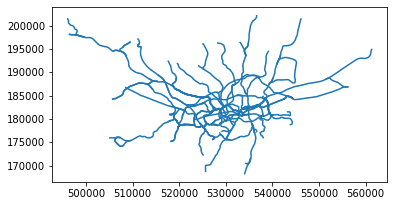

In [93]:
# plot to sanity check
edge_gdf.plot()

In [94]:
# let's store the length of the real geometry
edge_gdf["length"] = edge_gdf.geometry.length
edge_gdf.head()

,line_name,start_id,end_id,geometry,length
0,TfL Rail,910GLIVST,910GSTFD,"LINESTRING (533127.765 181621.330, 533254.998 ...",6698.461270
1,TfL Rail,910GSTFD,910GLIVST,"LINESTRING (538524.786 184373.341, 538519.900 ...",6698.461270
2,TfL Rail,910GSTFD,910GMRYLAND,"LINESTRING (538524.786 184373.341, 538519.900 ...",951.304721
3,TfL Rail,910GMRYLAND,910GFRSTGT,"LINESTRING (539211.234 184941.032, 539212.557 ...",1303.759071
4,TfL Rail,910GMANRPK,910GILFORD,"LINESTRING (541934.264 185711.949, 541935.596 ...",1831.469425


In [95]:
edge_gdf = edge_gdf.to_crs(epsg=27700)
edge_gdf.to_file("data/tfl_line_CLEANED.json", driver="GeoJSON")

In [96]:
# let's replace the ids with the actual nane
# get all station names
station_names_2 = {
    row.altmodeid: row["name"]
    for i, row in stations.iterrows()
    if row.altmodeid != None
}
station_names.update(station_names_2)

In [97]:
edge_gdf["start_id"] = edge_gdf["start_id"].apply(lambda x: station_names[x])
edge_gdf["end_id"] = edge_gdf["end_id"].apply(lambda x: station_names[x])

In [98]:
# make network
G = nx.from_pandas_edgelist(edge_gdf, source="start_id", target="end_id", edge_attr=["length", "line_name"])

In [101]:
# save position to graph
nx.set_node_attributes(G, pos, "pos")

{'Circle', 'London Overground', 'DLR', 'TfL Rail', 'Hammersmith & City', 'District', 'Bakerloo', 'Victoria', 'Jubilee', 'Waterloo & City', 'Central', 'Piccadilly', 'Metropolitan', 'Northern'}


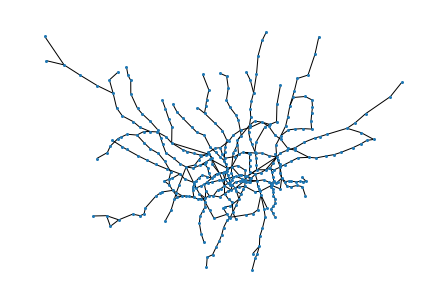

In [31]:
# let's plot
# notice that even though we created the real geometries, the graph still plots just straight line
# this is because networkx doesn't have a concept of a edge geometry
# however this is ok, since we only need the distance as weights, and that is already an attribute in our graph
pos = {
    row["name"]: row.geometry.coords[0]
    for i, row in stations.iterrows()
    if row["name"] in G.nodes()
}
Gcc = nx.connected_components(G)
for n in Gcc:
    G_sub = G.subgraph(n)
    lines = [data["line_name"] for u, v, data in G_sub.edges(data=True)]
    print(set(lines))
    nx.draw(G_sub, pos, node_size=4)
    plt.show()

In [32]:
node_list = list(G.nodes())
print(len(node_list))
edge_list = list(G.edges())
print(len(edge_list))

400
465


# Cost Travel Matrix

In [33]:
line_to_temp23 = {
    "Bakerloo": 29.89548504,
    "Central": 29.81688796,
    "Jubilee": 25.87475572,
    "Northern": 27.41207429,
    "Piccadilly": 26.83796676,
    "Victoria": 27.7313487,
    "Waterloo_and_City": 25.13049855,
    "Sub-surface_lines": 25.3775317,
    "Metropolitan": 24.80342609,
    "Hammersmith & City": 24.739941,
    "London Overground": 24.739941,
    "DLR": 24.739941,
    "District": 24.739941,
    "Circle": 24.739941,
    "TfL Rail": 24.739941,
}

line_to_temp26 = {
    "Bakerloo": 30.24458619,
    "Central": 30.23110336,
    "Jubilee": 26.26901359,
    "Northern": 27.7130721,
    "Piccadilly": 27.22379712,
    "Victoria": 28.14078849,
    "Waterloo_and_City": 25.13049855,
    "Sub-surface_lines": 25.3775317,
    "Metropolitan": 25.3775317,
    "Hammersmith & City": 25.3775317,
    "London Overground": 25.3775317,
    "DLR": 25.3775317,
    "District": 25.3775317,
    "Circle": 25.3775317,
    "TfL Rail": 25.3775317,
}


line_to_temp28 = {
    "Bakerloo": 30.47732029,
    "Central": 30.50724697,
    "Jubilee": 26.53185218,
    "Northern": 27.9137373,
    "Piccadilly": 27.48101737,
    "Victoria": 28.41374835,
    "Waterloo_and_City": 25.34854686,
    "Sub-surface_lines": 25.80259216,
    "Metropolitan": 25.80259216,
    "Hammersmith & City": 25.80259216,
    "London Overground": 25.80259216,
    "DLR": 25.80259216,
    "District": 25.80259216,
    "Circle": 25.80259216,
    "TfL Rail": 25.80259216,
}

line_temp_rank = {
    "Bakerloo": 6,
    "Central": 7,
    "Jubilee": 2,
    "Northern": 4,
    "Piccadilly": 3,
    "Victoria": 5,
    "Waterloo_and_City": 1.5,
    "Sub-surface_lines": 0,
    "Metropolitan": 0,
    "Hammersmith & City": 0,
    "London Overground": 0,
    "DLR": 0,
    "District": 0,
    "Circle": 0,
    "TfL Rail": 0,
}

for u, v, data in G.edges(data=True):
    line_name = data["line_name"]
    if line_name in line_to_temp23:
        data["temp23"] = line_to_temp23[line_name]
    if line_name in line_to_temp26:
        data["temp26"] = line_to_temp26[line_name]
    if line_name in line_to_temp28:
        data["temp28"] = line_to_temp28[line_name]
    if line_name in line_temp_rank:
        data["temp_rank"] = line_temp_rank[line_name]

In [34]:
# Check for stations with no line names
df = nx.to_pandas_edgelist(G)
na_rows = df[df['line_name'].isna()]
print(na_rows)

Empty DataFrame
Columns: [source, target, temp23, temp_rank, length, temp26, temp28, line_name]
Index: []


In [35]:
#Check temperature assignment were allocated correctly
for u, v, data in G.edges(data=True):
    line_name = data.get("line_name")  # Use data.get() to safely access attributes
    print(f"Edge attributes for {u} to {v} - line_name: {line_name}")
    if line_name in line_to_temp23:
        data["temp23"] = line_to_temp23[line_name]
    if line_name in line_to_temp26:
        data["temp26"] = line_to_temp26[line_name]
    if line_name in line_to_temp28:
        data["temp28"] = line_to_temp28[line_name]
    if line_name in line_temp_rank:
        data["temp_rank"] = line_temp_rank[line_name]

Edge attributes for Liverpool Street to Stratford - line_name: TfL Rail
Edge attributes for Liverpool Street to Aldgate - line_name: Metropolitan
Edge attributes for Liverpool Street to Moorgate - line_name: Hammersmith & City
Edge attributes for Liverpool Street to Bank - line_name: Central
Edge attributes for Liverpool Street to Bethnal Green - line_name: London Overground
Edge attributes for Liverpool Street to Aldgate East - line_name: Hammersmith & City
Edge attributes for Stratford to Maryland - line_name: TfL Rail
Edge attributes for Stratford to Stratford High Street - line_name: DLR
Edge attributes for Stratford to Pudding Mill Lane - line_name: DLR
Edge attributes for Stratford to Stratford International - line_name: DLR
Edge attributes for Stratford to Mile End - line_name: Central
Edge attributes for Stratford to Leyton - line_name: Central
Edge attributes for Stratford to Hackney Wick - line_name: London Overground
Edge attributes for Stratford to West Ham - line_name: Jub

## Distance

In [36]:
travel_cost_matrix = nx.shortest_path_length(G, weight="length")
travel_cost_df = pd.DataFrame(travel_cost_matrix).fillna(0)

## MAKE LIST
formatted_data = []

# Iterate over the rows in the DataFrame
for i, row in travel_cost_df.iterrows():
    origin_station = row[0]
    distances_dict = row[1]

    # Iterate over the distances dictionary
    for destination_station, distance in distances_dict.items():
        # Append the formatted data as a tuple to the list
        formatted_data.append((origin_station, destination_station, distance))

formatted_list = pd.DataFrame(formatted_data, columns=["source", "target", "length"])
formatted_list.to_csv("data/formatted_list.csv")

## Temperature
('temp_rank', 'temp23', 'temp26', 'temp28')


In [37]:
# Assuming you have already defined the graph 'G' and the weight attributes list
weight_attributes = ['temp_rank', 'temp23', 'temp26', 'temp28']  # Add more weight attributes as needed

# Create a dictionary to store the results dataframes
weight_results = {}

# Iterate over each weight attribute
for weight_attr in weight_attributes:
    results_list = []

    # Iterate over all nodes as source nodes
    for source_node in G.nodes():
        # Calculate the shortest paths and lengths for the current source node
        shortest_paths = nx.single_source_dijkstra(G, source_node, weight=weight_attr)

        # Iterate over all nodes as target nodes
        for target_node in G.nodes():
            # Check if there's a path from source to target
            if target_node in shortest_paths[1]:
                path_data = shortest_paths[1][target_node]
                path = path_data  # path_data is the length of the shortest path
                path_length = path_data
                num_nodes_in_path = len(path) - 1

                # Calculate the weighted shortest path
                weighted_shortest_path = sum(
                    G[path[i]][path[i + 1]][weight_attr]
                    if weight_attr in G[path[i]][path[i + 1]]
                    else 0
                    for i in range(len(path) - 1)
                )

                # Calculate actual distance of the journey
                journey_length = sum(
                    G[path[i]][path[i + 1]]["length"]
                    if "length" in G[path[i]][path[i + 1]]
                    else 0
                    for i in range(len(path) - 1)
                )

                # Append the results to the list
                results_list.append(
                    {
                        "Source": source_node,
                        "Target": target_node,
                        "Weighted_Path_Length": path_length,
                        "Num_Nodes_In_Path": num_nodes_in_path,
                        "Weighted_Shortest_Path": weighted_shortest_path,
                        "journey_distance": journey_length,
                    }
                )
                # Add the results to the list only if Weighted_Path_Length is not 0
                if path_length != 0:
                    results_list.append(
                        {
                            "Source": source_node,
                            "Target": target_node,
                            "Weighted_Path_Length": path_length,
                            "Num_Nodes_In_Path": num_nodes_in_path,
                            "Weighted_Shortest_Path": weighted_shortest_path,
                            "journey_distance": journey_length,
                        }
                    )


    # Create the DataFrame from the list of dictionaries
    weight_result = pd.DataFrame(results_list).drop_duplicates(subset=['Source', 'Target', 'Num_Nodes_In_Path', 'Weighted_Shortest_Path', 'journey_distance'])
    
     # Save the resulting dataframe as a separate file with the weight attribute in the filename
    filename = f"data/{weight_attr}_result.csv"
    weight_result.to_csv(filename, index=False)

    # Create a variable for the dataframe with the specified name
    if weight_attr == 'temp_rank':
        temp_rank_result = weight_result
    elif weight_attr == 'temp23':
        temp23_result = weight_result
    elif weight_attr == 'temp26':
        temp26_result = weight_result
    elif weight_attr == 'temp28':
        temp28_result = weight_result

    print(f"Saved results for weight attribute '{weight_attr}' as '{filename}'")

Saved results for weight attribute 'temp_rank' as 'data/temp_rank_result.csv'
Saved results for weight attribute 'temp23' as 'data/temp23_result.csv'
Saved results for weight attribute 'temp26' as 'data/temp26_result.csv'
Saved results for weight attribute 'temp28' as 'data/temp28_result.csv'


In [38]:
#Check if duplicates are actually removed.
temp26_result[temp26_result['Source'] == 'Uxbridge'].sort_values('Num_Nodes_In_Path', ascending = True)

,Source,Target,Weighted_Path_Length,Num_Nodes_In_Path,Weighted_Shortest_Path,journey_distance
121102,Uxbridge,Uxbridge,[Uxbridge],0,0.000000,0.000000
121104,Uxbridge,Hillingdon,"[Uxbridge, Hillingdon]",1,25.377532,2144.395127
121106,Uxbridge,Ickenham,"[Uxbridge, Hillingdon, Ickenham]",2,50.755063,3268.832323
121108,Uxbridge,Ruislip,"[Uxbridge, Hillingdon, Ickenham, Ruislip]",3,76.132595,5054.487305
121110,Uxbridge,Ruislip Manor,"[Uxbridge, Hillingdon, Ickenham, Ruislip, Ruis...",4,101.510127,5733.373285
...,...,...,...,...,...,...
120940,Uxbridge,Upminster Bridge,"[Uxbridge, Hillingdon, Ickenham, Ruislip, Ruis...",31,769.745450,62210.794262
120938,Uxbridge,Hornchurch,"[Uxbridge, Hillingdon, Ickenham, Ruislip, Ruis...",31,770.636932,59098.516501
121196,Uxbridge,Elverson Road,"[Uxbridge, Hillingdon, Ickenham, Ruislip, Ruis...",31,769.901865,46387.305547
120826,Uxbridge,Shenfield,"[Uxbridge, Hillingdon, Ickenham, Ruislip, Ruis...",32,795.122982,67949.672144


## Statistics and Visualisation

#### How temperature weighted routes affect travel safety and average temp

In [39]:
#Average journey temperature to the top 100 Heat Resilient Stations
top100 = pd.read_csv("data/top_100_final_score.csv")

# Calculating the average temperature of journeys from source to target
temp26_result["avg_temp"] = temp26_result["Weighted_Shortest_Path"] / temp26_result["Num_Nodes_In_Path"]
temp_per_dest = temp26_result.sort_values("avg_temp", ascending=False)
top100_travel_temp=top100.merge(temp_per_dest, left_on = 'buffer_name', right_on = 'Target', how = 'left' )
top100_travel_temp.drop(['buffer_name', 'final_score_transformed'], axis = 1, inplace = True)
top100_travel_temp = top100_travel_temp.sort_values("avg_temp", ascending=False)

# # Average journey temperature
temp28_result["avg_temp"] = temp28_result["Weighted_Shortest_Path"] / temp28_result["Num_Nodes_In_Path"]
temp_per_dest28 = temp28_result.sort_values("avg_temp", ascending=False)
top100_travel_temp28=top100.merge(temp_per_dest28, left_on = 'buffer_name', right_on = 'Target', how = 'left' )
top100_travel_temp28 = top100_travel_temp28.sort_values("avg_temp", ascending=False)

#Output
print(f" The average journey temperature to {len(top100_travel_temp[top100_travel_temp['avg_temp'] > 26])} out of {len(top100_travel_temp)} top Heat resilient stations are above 26C when air temp is 26")
print(len(top100_travel_temp28[top100_travel_temp['avg_temp'] > 26])/len(top100_travel_temp) )
print(f" The average journey temperature to {len(top100_travel_temp28[top100_travel_temp28['avg_temp'] > 26])} out of {len(top100_travel_temp28)} top Heat resilient stations are above 26C, when air temp is 28")
print(len(top100_travel_temp28[top100_travel_temp28['avg_temp'] > 26])/len(top100_travel_temp28) )

 The average journey temperature to 19189 out of 40000 top Heat resilient stations are above 26C when air temp is 26
0.479725
 The average journey temperature to 24701 out of 40000 top Heat resilient stations are above 26C, when air temp is 28
0.617525


/tmp/ipykernel_33077/3967093485.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(top100_travel_temp28[top100_travel_temp['avg_temp'] > 26])/len(top100_travel_temp) )


#### How temperature weighted routes affect travel length

Conclusion, not too much. journey increased by an average of 8%, median 9%

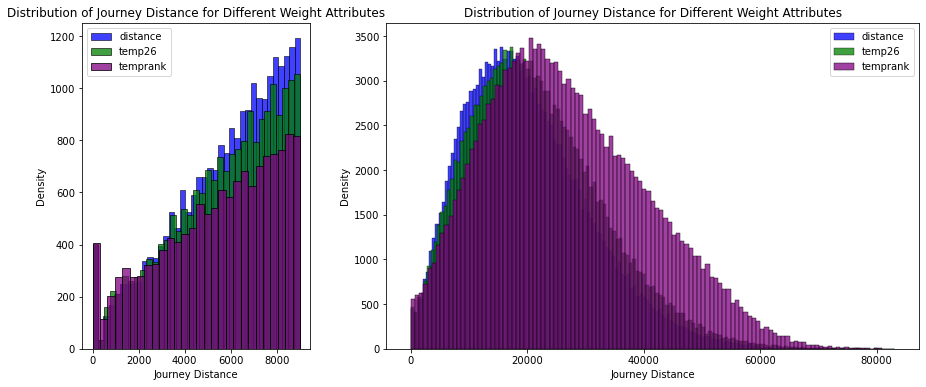

In [40]:
formatted_list9000 = formatted_list[formatted_list['length'] < 9000 ]
temp26_result9000 = temp26_result[temp26_result['journey_distance'] < 9000 ]
temp_rank_result9000 = temp_rank_result[temp_rank_result['journey_distance'] < 9000 ]

fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [0.3, 0.7]})
sns.histplot(formatted_list9000["length"], label='distance', color='blue', ax=axs[0])
sns.histplot(temp26_result9000["journey_distance"], label='temp26', color='green', ax=axs[0])
sns.histplot(temp_rank_result9000["journey_distance"], label='temprank', color='purple', ax=axs[0])

axs[0].legend()
axs[0].set_xlabel("Journey Distance")
axs[0].set_ylabel("Density")
axs[0].set_title("Distribution of Journey Distance for Different Weight Attributes")

# Plot the distributions with different colors
sns.histplot(formatted_list["length"], label='distance', color='blue', ax=axs[1])
sns.histplot(temp26_result["journey_distance"], label='temp26', color='green', ax=axs[1])
sns.histplot(temp_rank_result["journey_distance"], label='temprank', color='purple', ax=axs[1])

axs[1].legend()
axs[1].set_xlabel("Journey Distance")
axs[1].set_ylabel("Density")
axs[1].set_title("Distribution of Journey Distance for Different Weight Attributes")

plt.savefig("output/journey_length.png")


# Show the plot
plt.show()

In [41]:
avg_journey_inc = (
    temp26_result["journey_distance"].mean() - formatted_list["length"].mean()
) / formatted_list["length"].mean()
print(f" In temperature weighted journeys, mean journey increased by {avg_journey_inc}")

avg_journey_inc = (
    temp_rank_result["journey_distance"].mean() - formatted_list["length"].mean()
) / formatted_list["length"].mean()
print(f" In temperature rank weighted journeys, mean journey increased by {avg_journey_inc}")

 In temperature weighted journeys, mean journey increased by 0.08345701242741163
 In temperature rank weighted journeys, mean journey increased by 0.34055250924066605


# STAGE 1

## Merging with usage data

In [42]:
lin_reg_results_pval = pd.read_csv("data/lin_reg_results_pval.csv")
lin_reg_results_28C_pvalue = pd.read_csv("data/lin_reg_results_28C_pvalue.csv")

In [43]:
station_df = pd.DataFrame(stations)
alltemp_lines =lin_reg_results_pval.merge(station_df, left_on = 'station', right_on = 'name', how = 'left')
alltemp_lines.drop_duplicates(subset=['station'], inplace = True)

temp28_lines =lin_reg_results_28C_pvalue.merge(station_df, left_on = 'station', right_on = 'name', how = 'left')
temp28_lines.drop_duplicates(subset=['station'], inplace = True)
temp28_lines= temp28_lines[temp28_lines['station']!= 'West Croydon'] 

In [44]:
coollines = ["Sub-surface_lines", "Metropolitan", "Hammersmith & City", "London Overground", "DLR", "District", "Circle", "TfL Rail"]

pos_alltemp_lines = alltemp_lines[alltemp_lines['coef_sign'] == 1]
neg_alltemp_lines = alltemp_lines[alltemp_lines['coef_sign'] == 0]

# alllines = ["Bakerloo","Central","Jubilee","Northern","Piccadilly","Victoria","Waterloo_and_City","Sub-surface_lines","Metropolitan","Hammersmith & City","London Overground","DLR","District","Circle","TfL Rail"]

pos_temp28_lines = temp28_lines[temp28_lines['coef_sign'] == 1]
neg_temp28_lines = temp28_lines[temp28_lines['coef_sign'] == 0]

In [45]:
pos_alltemp_lines_stnnames= pos_alltemp_lines['station'].tolist()

In [46]:
print(len(pos_alltemp_lines))
print(len(neg_alltemp_lines))
print(len(pos_temp28_lines))
print(len(neg_temp28_lines))

56
13
21
37


In [47]:
def has_cool_line(line_str):
    for cool_line in coollines:
        if cool_line in line_str:
            return True
    return False

pos_cool = pos_alltemp_lines[pos_alltemp_lines['lines'].apply(has_cool_line)]
neg_cool = neg_alltemp_lines[neg_alltemp_lines['lines'].apply(has_cool_line)]

pos28_cool = pos_temp28_lines[pos_temp28_lines['lines'].apply(has_cool_line)]
neg28_cool = neg_temp28_lines[neg_temp28_lines['lines'].apply(has_cool_line)]

In [48]:
print(len(neg_cool))
print(len(pos_cool))
print(len(neg28_cool))
print(len(pos28_cool))

4
49
19
11


## Normal percent_daily usage data

In [58]:
node_data = {}

# Iterate over the DataFrame rows
for _, row in lin_reg_results_pval.iterrows():
    node = row["station"]
    data = row["tmax"]

    # Add node data to the dictionary
    node_data[node] = data

    # Set the default value of 0 for nodes that do not exist in the DataFrame
for node in G.nodes():
    if node not in node_data:
        node_data[node] = 0

# Set the node attributes in the network
nx.set_node_attributes(G, node_data, "tmax")

In [55]:
nodes_without_position = []

for node in G.nodes():
    if node not in pos:
        nodes_without_position.append(node)

if len(nodes_without_position) > 0:
    print("Nodes without position:")
    print(nodes_without_position)
else:
    print("All nodes have positions.")

Nodes without position:
['Liverpool Street', 'Stratford', 'Maryland', 'Forest Gate', 'Manor Park', 'Ilford', 'Seven Kings', 'Goodmayes', 'Chadwell Heath', 'Romford', 'Gidea Park', 'Harold Wood', 'Brentwood', 'Shenfield', 'Earls Court', 'Gloucester Road', 'West Kensington', 'Barons Court', 'Hammersmith', 'Ravenscourt Park', 'Stamford Brook', 'Turnham Green', 'Chiswick Park', 'Acton Town', 'Ealing Common', 'South Kensington', 'Sloane Square', 'Ealing Broadway', 'Richmond', 'Kew Gardens', 'Gunnersbury', 'West Brompton', 'Wimbledon Park', 'Southfields', 'East Putney', 'Putney Bridge', 'Parsons Green', 'Fulham Broadway', 'High Street Kensington', 'Notting Hill Gate', 'Bayswater', 'Paddington', 'Edgware Road', 'Victoria', 'St Jamess Park', 'Westminster', 'Embankment', 'Temple', 'Blackfriars', 'Mansion House', 'Cannon Street', 'Monument', 'Tower Hill', 'Aldgate East', 'Whitechapel', 'Stepney Green', 'Mile End', 'Bow Road', 'Bromley-by-Bow', 'West Ham', 'Plaistow', 'Upton Park', 'East Ham', 'B

NetworkXError: Node 'Liverpool Street' has no position.

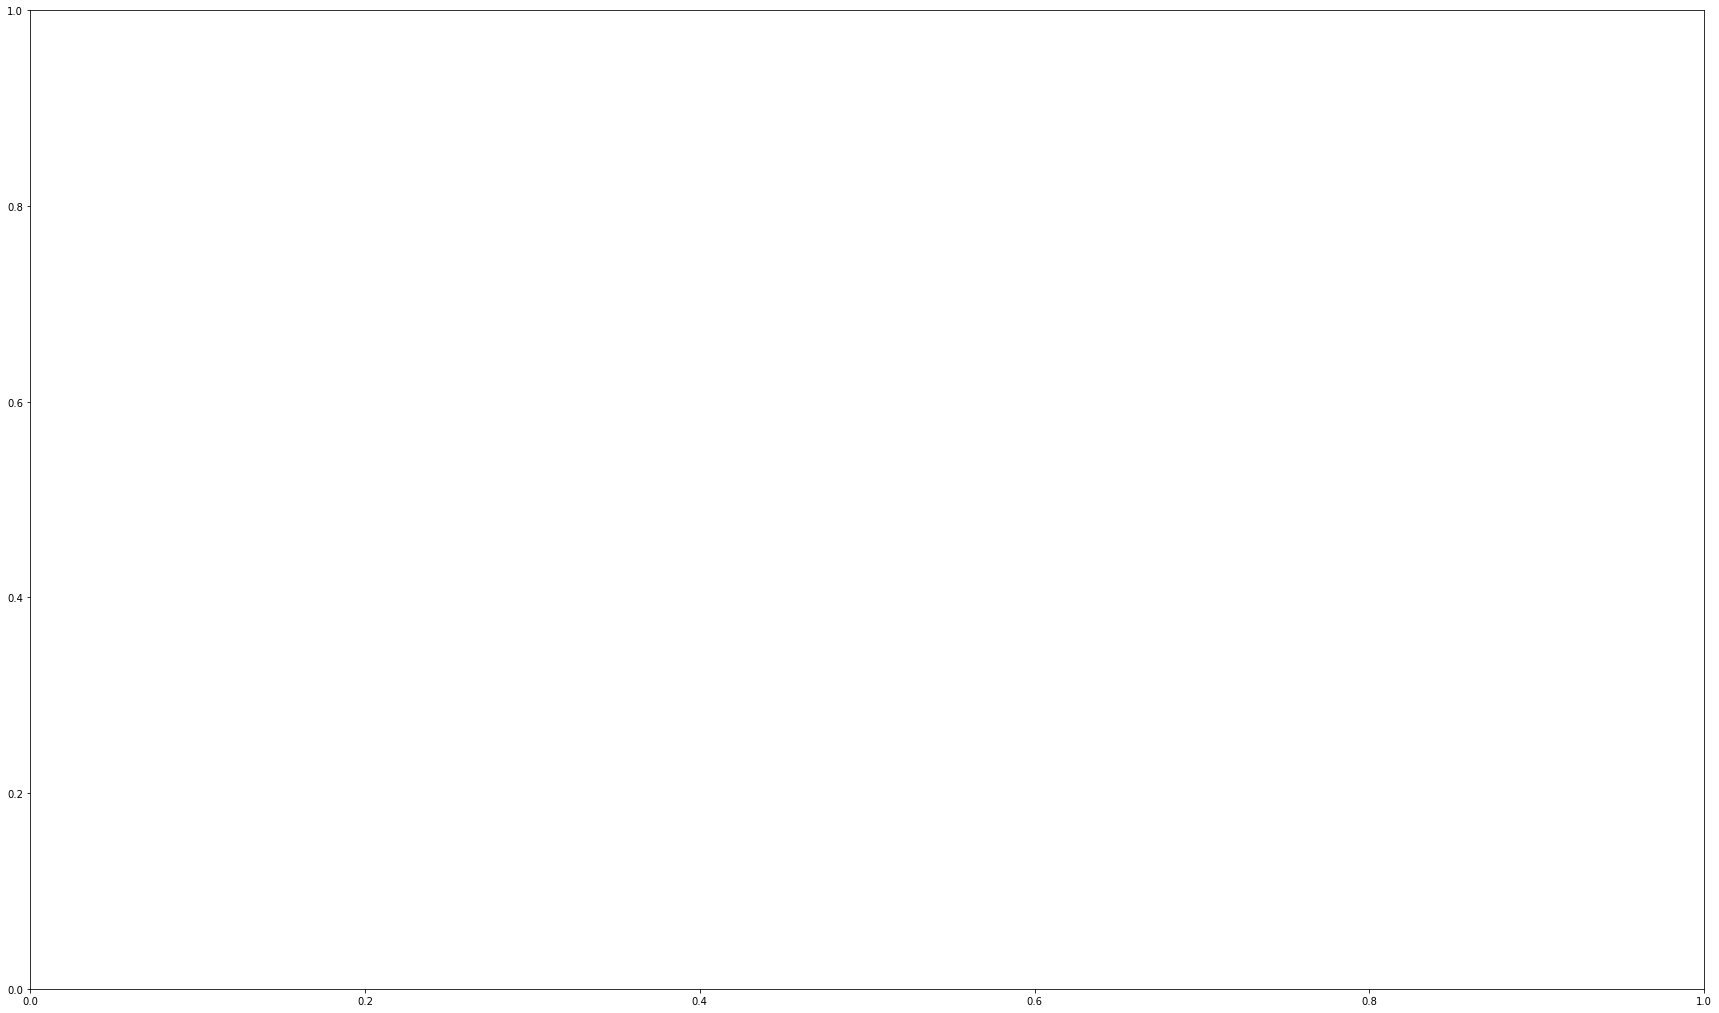

In [56]:
cmap = cm.seismic

tmax_val = [(i[1]["tmax"]) for i in G.nodes(data=True)]

fig, ax = plt.subplots(1, 1, figsize=(30, 18))

# Calculate node colors and sizes
max_tmax = max(tmax_val)
node_color = [(data["tmax"] / max_tmax) for _, data in G.nodes(data=True)]
node_size = 50  # Adjust node size here

# Create a dictionary of node colors
node_color_dict = {node: color for node, color in zip(G.nodes(), node_color)}

# Plot the network with node colors and labels
nx.draw_networkx_nodes(
    G, pos, node_color=[node_color_dict[node] for node in G.nodes()],
    cmap=cmap, vmin=-0.00017, vmax=0.00017, node_size=node_size,
    alpha=[1 if node_color_dict[node] != 0 else 0 for node in G.nodes()]
)

# Plot the network with node colors and labels
nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes() if node_color_dict[node] != 0},
                        font_size=12, horizontalalignment='left', verticalalignment='bottom')

# Add a colorbar to the plot
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-0.00017, vmax=0.00017))
sm.set_array([])
cbar = plt.colorbar(sm)

ax.set_xlim([505000, 555000])
ax.set_ylim([171000, 193000])

# Save the plot
plt.savefig("output/usage_real_data_network.png")

plt.show()


In [60]:
node_data = {}

# Iterate over the DataFrame rows
for _, row in lin_reg_results_28C_pvalue.iterrows():
    node = row["station"]
    data = row["tmax"]

    # Add node data to the dictionary
    node_data[node] = data

    # Set the default value of 0 for nodes that do not exist in the DataFrame
for node in G.nodes():
    if node not in node_data:
        node_data[node] = 0


# Set the node attributes in the network
nx.set_node_attributes(G, node_data, "tmax28")

NetworkXError: Node 'Liverpool Street' has no position.

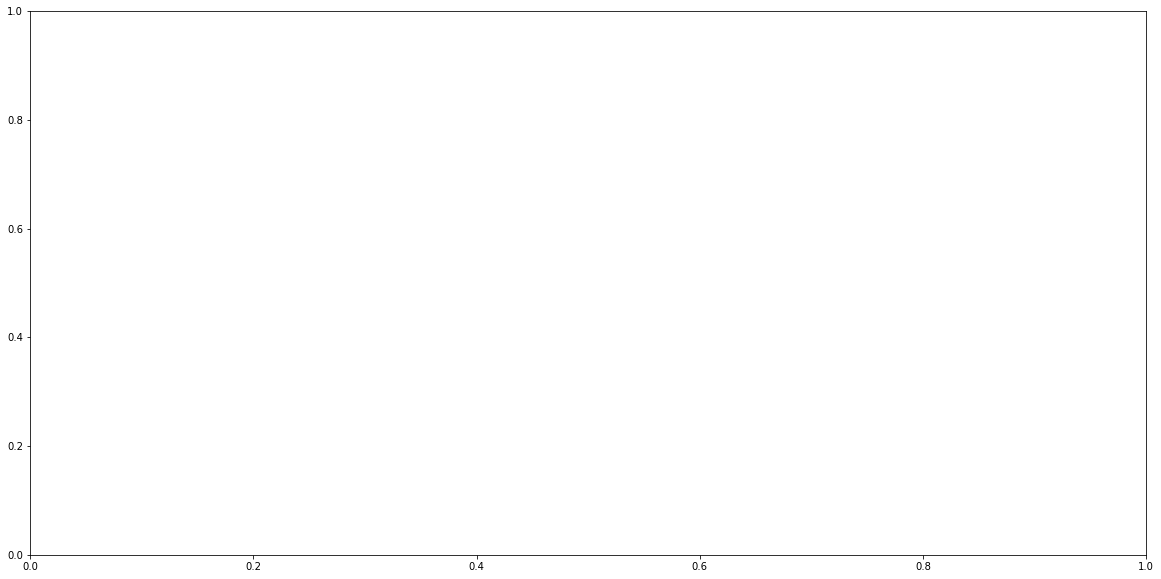

In [53]:
cmap = plt.cm.seismic  # colour scheme

tmax_val = [(i[1]["tmax28"]) for i in G.nodes(data=True)]

node_color = [(i[1]["tmax28"] / max(tmax_val)) for i in G.nodes(data=True)]

pos = nx.get_node_attributes(
    G, "coords"
)  # now using the coord as position instead of the length

plt.figure(figsize=(20, 10))

# Create a dictionary of node colors
node_color_dict = {node: color for node, color in zip(G.nodes(), node_color)}

nx.draw_networkx_nodes(
    G, pos, node_color=[node_color_dict[node] for node in G.nodes()],
    cmap=cmap, vmin=-0.00017, vmax=0.00017, node_size=50,
    alpha=[1 if node_color_dict[node] != 0 else 0 for node in G.nodes()]
)

# Plot the network with node colors and labels
nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes() if node_color_dict[node] != 0},
                        font_size=10, horizontalalignment='left', verticalalignment='bottom')

# Add a colorbar to the plot
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-0.00017, vmax=0.00017))
sm.set_array([])
cbar = plt.colorbar(sm)

ax.set_xlim([514000, 583000])
ax.set_ylim([175000, 200000])

# plt.title("Stations with a positive/negative correlation when temperatures are above 28C", fontsize=15)
plt.savefig("output/usage_real_data_network28.png")
plt.show()